# Neural Networks using NumPy

<div class="toc"><ul class="toc-item"><li><span><a href="#Implementation-of-Layers" data-toc-modified-id="Implementation-of-Layers-1">Implementation of Layers</a></span><ul class="toc-item"><li><span><a href="#Fully-Connected-Layer" data-toc-modified-id="Fully-Connected-Layer-1.1">Fully Connected Layer</a></span></li><li><span><a href="#ReLU-and-Softmax-Activation-Functions" data-toc-modified-id="ReLU-and-Softmax-Activation-Functions-1.2">ReLU and Softmax Activation Functions</a></span></li><li><span><a href="#Cross-Entropy-Loss" data-toc-modified-id="Cross-Entropy-Loss-1.3">Cross Entropy Loss</a></span></li></ul></li><li><span><a href="#Image-Classification" data-toc-modified-id="Image-Classification-2">Image Classification</a></span><ul class="toc-item"><li><span><a href="#Data-Preparation-and-Other-Utilities" data-toc-modified-id="Data-Preparation-and-Other-Utilities-2.1">Data Preparation and Other Utilities</a></span></li><li><span><a href="#Two-classes" data-toc-modified-id="Two-classes-2.2">Two classes</a></span></li><li><span><a href="#Five-classes" data-toc-modified-id="Five-classes-2.3">Five classes</a></span></li></ul></li></ul></div>

In [1]:
#importing the required packages
import numpy as np
import pickle
from matplotlib import pyplot as plt
from skimage.feature import hog

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

In [ ]:
from .nn.activation import *
from .nn.linear import *
from .nn.loss import *
from .nn.module import *

## Implementation of Layers

First, we define a class called `Module` which will serve as the base class for definining any other Neural Network modules or layers further on. This, in general, is a good practice since we can define all the necessary functions which are common to all modules that are defined or will be defined. This allows users to define their own modules without re-defining all the common necessary functions. However, in our case, the class `Module` is a dummy class which basically passes the input (in the forward pass) and the gradients (in the backward pass) ahead without modifying them. This is because we re-define all the three basic functions `__init__`, `forward` and `backward` in all the layer classes later.

In [2]:
#the base class for any layer or module
class Module:
    def __init__(self):
        return
    
    def forward(self, inputBatch):
        return inputBatch
    
    def backward(self, gradients):
        g = np.eye(gradients.shape[1])
        return np.dot(gradients, g)

### Fully Connected Layer

In the `forward` pass, the Fully Connected or the `Linear` layer class applies a linear transformation to the input $\mathbf{x}$ using a weight matrix $\mathbf{W}$ and a bias vector $\mathbf{b}$ as follows:

$$ \mathbf{z} = \mathbf{x}\mathbf{W}^T + \mathbf{b} $$

where $\mathbf{x}$ is a row vector of size $F_{in}$, $\mathbf{z}$ is a row vector of size $F_{out}$, $\mathbf{W}$ is a matrix of size $(F_{out}, F_{in})$ and $\mathbf{b}$ is a row vector of size $F_{out}$. The weight matrix and the bias vector are initialized similarly as in the PyTorch framework.

**Note**: In mini-batch gradient descent, the size of the input would be $(N, F_{in})$ and the size of the output will be $(N, F_{out})$ with $N$ being the size of the mini-batch. However, for the purpose of illustration we use single samples.

<br><br>

In the `backward` pass, the `Linear` layer needs to calculate the output derivatives with respect to the weight matrix $\mathbf{W}$, the bias vector $\mathbf{b}$ and the input $\mathbf{x}$. These output derivatives are multiplied to the loss gradients received from the further layers to get the loss gradients with respect to the layer parameters. The layer stores the loss gradients with respect to the weight matrix and the bias vector and uses them later to update the parameters. The loss gradients with respect to the input are passed on to the previous layers. 

The output derivatives described above are as follows:

$$
\begin{align*}
\frac{\partial \mathbf{z}}{\partial \mathbf{W}} &= \mathbf{x}^T \\[1em]
\frac{\partial \mathbf{z}}{\partial \mathbf{b}} &= \mathbf{I} \\[1em]
\frac{\partial \mathbf{z}}{\partial \mathbf{x}} &= \mathbf{W}
\end{align*}
$$

where $\mathbf{I}$ is an Identity matrix of size $(F_{out}, F_{out})$.

Since the value of the input is required during the backward pass, the layer stores the input in a `cache` variable during the forward pass which is then used during the backward pass.

**Note**: In mini-batch gradient descent, the loss gradients are computed and passed on for each sample in the mini-batch. The loss gradients with respect to the layer parameters are averaged over all the samples in the mini-batch and this average loss gradient value is stored for updating the parameters later.

<br><br>

Once the loss gradients are computed, the layer parameters are updated in the `step` function according to the Gradient Descent update rule:

$$ \Theta = \Theta -  \alpha \frac{\partial L}{\partial \Theta}$$

where $\Theta = \{\mathbf{W}, \mathbf{b}\}$, $\alpha$ is the learning rate and $L$ is the loss. 

<br><br>

Also, the `num_params` function gives the total number of trainable parameters of the `Linear` layer. It is the number of elements in the weight matrix $\mathbf{W}$ i.e. $F_{out} F_{in}$ added to the number of elements in the bias vector $\mathbf{b}$ i.e. $F_{out}$. 

In our case, only the `Linear` layer has trainable parameters and therefore the `step` and the `num_param` functions are defined only for the `Linear` layer.

In [3]:
#definition for the Linear layer class
class Linear(Module):
    
    """
    Fully Connected layer that applies a linear transformation to the input using weights and biases.
    y = w.x + b
    
    Shapes:
    Input - (N, Fin)
    Output - (N, Fout)
    In Gradients - (N, Fout)
    Out Gradients - (N, Fin)
    """
    
    def __init__(self, inFeatures, outFeatures, learningRate):
        super(Linear, self).__init__()
        self.inFeatures = inFeatures
        self.outFeatures = outFeatures
        self.lr = learningRate
        
        #declaring the weight and bias dictionaries for storing their values and gradients
        self.weight = dict()
        self.bias = dict()
        
        #initializing the weight and bias values and gradients
        self.weight["grad"] = None
        self.bias["grad"] = None
        self.weight["val"] = np.random.uniform(-np.sqrt(1/inFeatures), np.sqrt(1/inFeatures), size=(outFeatures, inFeatures))
        self.bias["val"] = np.random.uniform(-np.sqrt(1/inFeatures), np.sqrt(1/inFeatures), size=(outFeatures))
        
        #declaring and initializing the cache dictionary
        self.cache = dict()
        self.cache["input"] = None
        return
    
    
    def forward(self, inputBatch):
        #computing the linear transformation and storing the inputs in the cache
        outputBatch = np.dot(inputBatch, self.weight["val"].T) + self.bias["val"]
        self.cache["input"] = inputBatch
        return outputBatch
    
    
    def backward(self, gradients):
        #computing the gradients wrt the weight
        [N, Fin] = self.cache["input"].shape
        wGrad = np.einsum('no,ni->noi', gradients, self.cache["input"])
        self.weight["grad"] = np.mean(wGrad, axis=0)
        
        #computing the gradients wrt the bias
        bGrad = np.dot(gradients, np.eye(gradients.shape[1]))
        self.bias["grad"] = np.mean(bGrad, axis=0)
        
        #computing the gradients wrt the input
        inGrad = self.weight["val"]
        return np.dot(gradients, inGrad)
    
    
    def step(self):
        #weight and bias values update
        self.weight["val"] = self.weight["val"] - self.lr*self.weight["grad"]
        self.bias["val"] = self.bias["val"] - self.lr*self.bias["grad"]
        return
    
    
    def num_params(self):
        #total number of trainable parameters in the layer
        numParams = (self.weight["val"].shape[0]*self.weight["val"].shape[1]) + self.bias["val"].shape[0]
        return numParams

### ReLU and Softmax Activation Functions

In the `forward` pass, the `ReLU` layer applies the ReLU operation elementwise on the input $\mathbf{z}$. The ReLU operation is defined as:

$$ \mathbf{a} = \text{ReLU}(\mathbf{z}) = \max(0,\mathbf{z}) $$

where $\mathbf{z}$ and $\mathbf{a}$ are row vectors of size $F$. The ReLU operation clips all the negative values to $0$ while keeping the positive values unmodified. 

<br><br>

In the `backward` pass, the `ReLU` layer calculates the output derivative with respect to the input $\mathbf{z}$ as follows:  

$$
\begin{align*}
\frac{\partial \mathbf{a}}{\partial \mathbf{z}} &= \text{diag}\left(\frac{\partial a_0}{\partial z_0}, \dots, \frac{\partial a_i}{\partial z_i}, \dots, \frac{\partial a_{F-1}}{\partial z_{F-1}} \right)\\[1em]
\frac{\partial a_i}{\partial z_i} &= 
\begin{cases} 
  0 & \max(0,z_i) = 0 \equiv z_i \leq 0\\
  1 & \max(0,z_i) = z_i \equiv z_i > 0
\end{cases}
\end{align*}
$$

Since we only need to know whether the ReLU was active ($z_i > 0$) or inactive ($z_i \leq 0$) at a position $i$ for computing the output derivatives in the backward pass, we store only a boolean map of size $F$ denoting whether the ReLU was active at that position in the `cache` variable.

<br><br>

The `ReLU` layer has no trainable parameters.

In [4]:
#definition for the ReLU layer class
class ReLU(Module):
    
    """
    Applies the ReLU function on each element of the input block.
    y = max(0,x)
    
    Shapes:
    Input - (N,F)
    Output - (N,F)
    In Gradients - (N,F)
    Out Gradients - (N,F)
    """
    
    def __init__(self):
        super(ReLU, self).__init__()
        #declaring and initializing the cache dictionary 
        self.cache = dict()
        self.cache["active"] = None
        return
    
    
    def forward(self, inputBatch):
        #applying the ReLU operation and storing a map showing where ReLU was active
        outputBatch = np.maximum(0, inputBatch)
        self.cache["active"] = (inputBatch > 0)
        return outputBatch
    
    
    def backward(self, gradients):
        #computing the gradients wrt the input
        inGrad = np.zeros(self.cache["active"].shape)
        inGrad[self.cache["active"]] = 1
        return gradients*inGrad

In the `forward` pass, the `Softmax` layer applies the Softmax operation on the input $\mathbf{z}$. The Softmax operation is used to convert the input $\mathbf{z}$ to a probability distribution so that the elements in $\mathbf{z}$ sum to $1$ and each element lies between $0$ and $1$. The Softmax operation is defined as:

$$ 
\begin{align*}
\mathbf{a} &= \text{Softmax}(\mathbf{z})\\[1em]
a_i &= \frac{e^{z_i}}{\sum_{j=0}^{F-1} e^{z_j}} \quad \forall i \in \{0, \dots, F-1\}
\end{align*}
$$

where $\mathbf{z}$ and $\mathbf{a}$ are row vectors of size $F$. 

If the values of elements of $\mathbf{z}$ are high, the exponent values may cross the `float` datatype limits and thus we would get `nan` in the softmax output. Thus for numerical stability, we modify the softmax operation along with a correction factor $D$ as follows:

$$ a_i = \frac{e^{z_i - D}}{\sum_{j=0}^{F-1} e^{z_j - D}} \quad \forall i \in \{0, \dots, F-1\} $$

The correction factor $D$ is generally taken to be $\max(z_0, \dots, z_{F-1})$. Using the correction factor, we avoid `nan` in output while not changing the actual Softmax output values.

<br><br>

In the `backward` pass, the `Softmax` layer calculates the output derivative with respect to the input $\mathbf{z}$ as follows:  
$$
\begin{align*}
\left( \frac{\partial \mathbf{a}}{\partial \mathbf{z}} \right)_{ij} &= \frac{\partial a_i}{\partial z_j} \quad \forall i,j \in \{ 0,\dots,F-1 \}\\[1em]
\frac{\partial a_i}{\partial z_j} &= a_i(\delta_{ij} - a_j)
\end{align*}
$$

where $\delta_{ij}$ is the Kroneker Delta defined as:

$$ 
\delta_{ij} = 
\begin{cases} 
  0 & i \neq j\\
  1 & i = j
\end{cases}
$$

Since we need the output values for the output derivative computation in backward pass, we store the outputs computed in the forward pass in the `cache` variable which is then used during the backward pass.

<br><br>

The `Softmax` layer has no trainable parameters.

In [5]:
#definition for the Softmax layer class    
class Softmax(Module):
    
    """
    Applies the Softmax function along the last axis/dimension of the input batch
    yi = exp(xi)/sum_j(exp(xj))
    
    Shapes:
    Input - (N,F)
    Output - (N,F)
    In Gradients - (N,F)
    Out Gradients - (N,F)
    """
    
    def __init__(self):
        super(Softmax, self).__init__()
        #declaring and initializing the cache dictionary
        self.cache = dict()
        self.cache["output"] = None
        return
    
    
    def forward(self, inputBatch):
        #computing the exponential values along with a correction factor for numerical stability
        correction = np.max(inputBatch, axis=1, keepdims=True)
        expVals = np.exp(inputBatch - correction)
        
        #computing the softmax operation
        outputBatch = expVals/np.sum(expVals, axis=1, keepdims=True)
        
        #storing the outputs in the cache
        self.cache["output"] = outputBatch
        return outputBatch
    
    
    def backward(self, gradients):
        #computing the gradients wrt the input
        [N,F] = self.cache["output"].shape
        delta = np.eye(F,F)
        delta = np.reshape(delta, (1,F,F))
        output = np.reshape(self.cache["output"], (N,1,F))
        inGrad = output.transpose(0,2,1)*(delta - output)
        return np.einsum('nf,nfd->nd', gradients, inGrad)

### Cross Entropy Loss

The `CrossEntropyLoss` layer is used for implementing the Cross Entropy Loss function. This loss function is generally used in classification tasks with 2 or more classes as the output. In the `forward` pass, the `CrossEntropyLoss` layer computes the loss given the model output probability distribution $\mathbf{y}$ and the target class $T$. The Cross Entropy Loss function is computed as follows:

$$ Loss = -\log y_T $$

where $\mathbf{y}$ is a row vector of size $C$ and $T \in \{0, \dots, C-1\}$ with $C$ being the number of classes.

**Note**: For a mini-batch, the loss values for each sample is computed and the average loss over all the samples is given as the output loss value.

<br><br>

In the `backward` pass, the `CrossEntropyLoss` layer calculates the loss gradient with respect to the model output distribution  $\mathbf{y}$ as follows:  

$$
\begin{align*}
\left( \frac{\partial \text{Loss}}{\partial \mathbf{y}} \right)_i &= \frac{\partial \text{Loss}}{\partial y_i}\\[1em]
\frac{\partial \text{Loss}}{\partial y_i} &= 
\begin{cases} 
  0 & i \neq T\\
  -\frac{1}{y_T} & i = T
  \end{cases}
\end{align*}
$$

Since we need the model output probability of the target class i.e $y_T$ and the target class $T$ for computation of loss gradient in the backward pass, we store them during the forward pass in the `cache` variable and use them during the backward pass.

<br><br>

The `CrossEntropyLoss` layer has no trainable parameters.

In [6]:
#definition for the Cross Entropy Loss layer class
class CrossEntropyLoss(Module):
    
    """
    Computes the cross entropy loss using the output and the required target class.
    loss = -log(yHat[class])
    
    Shapes:
    Outputs - (N,C)
    Classes - (N)
    Out Gradients - (N,C)
    """
    
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()
        #declaring and initializing the cache dictionary
        self.cache = dict()
        self.cache["scores"] = None
        self.cache["classes"] = None
        self.cache["numClasses"] = None
        return
    
    
    def forward(self, outputs, classes):
        #computing the loss for each sample in the batch and averaging the loss
        scores = outputs[np.arange(outputs.shape[0]), classes]
        loss = -np.mean(np.log(scores))
        
        #storing the scores and classes in cache
        self.cache["scores"] = scores
        self.cache["classes"] = classes
        self.cache["numClasses"] = outputs.shape[1]
        return loss
    
    
    def backward(self):
        #computing the loss gradients
        N = len(self.cache["classes"])
        gradients = np.zeros((N, self.cache["numClasses"]))
        gradients[np.arange(N), self.cache["classes"]] = -1./self.cache["scores"]
        return gradients

## Image Classification

### Data Preparation and Other Utilities

We use the `CIFAR-10` dataset for our task. `CIFAR-10` dataset consists of $10$ classes with $5000$ training set and $1000$ test set 32 x 32 RGB images for each class. We perform two tasks using our Neural Network: 

1. Two class classification (`Airplane`(0) / `Ship`(1)) 
2. Five class classification (`Cat`(0) / `Deer`(1) / `Dog`(2) / `Frog`(3) / `Horse`(4))

We extract the complete dataset and convert the images to 32 x 32 grayscale images with pixel intensity values between $0$ and $1$.  

In [7]:
#function which takes a pickle file as input and outputs the file contents in form of dictionary
def unpickle(file):
    with open(file, 'rb') as fo:
        dic = pickle.load(fo, encoding='bytes')
    return dic

basePath = "./CIFAR10/data_batch_"

#reading and storing the training set
trainImages = np.empty((0,3072), dtype=np.float32)
trainLabels = list()
for i in range(1,6):
    trainset = unpickle(basePath + str(i))
    trainImages = np.vstack((trainImages, trainset[b"data"].astype(np.float32)))
    trainLabels.extend(trainset[b"labels"])
trainLabels = np.array(trainLabels)

#reading and storing the test set
testset = unpickle("./CIFAR10/test_batch")
testImages = testset[b"data"].astype(np.float32)
testLabels = np.array(testset[b"labels"])

#reading the meta file for the label names
labelNames = unpickle("./CIFAR10/batches.meta")[b"label_names"]

In [8]:
#converting the RGB images to grayscale, scaling them to 0-1 and reshaping them to 32x32
trainImages = (0.299*trainImages[:,:1024] + 0.587*trainImages[:,1024:2048] + 0.114*trainImages[:,2048:])/255.0
trainImages = trainImages.reshape((trainImages.shape[0], 32, 32))

testImages = (0.299*testImages[:,:1024] + 0.587*testImages[:,1024:2048] + 0.114*testImages[:,2048:])/255.0
testImages = testImages.reshape((testImages.shape[0], 32, 32))

**Training Steps**

For one epoch:
1. Divide the training data set into batches depending upon the batch size.
2. For each batch, do a forward pass of the model and obtain the model outputs.
3. Given the model outputs and the target labels for the batch, compute the loss value.
4. Perform a backward pass on the loss function and the model for obtaining the values of loss gradient with respect to the model parameters.
5. Perform one step of Gradient Descent update to update the model parameters.
6. Repeat from 2. for all batches.

`train` - Trains the model for one epoch over the training set as described above. After training the model for one epoch, the function computes the per sample average training set loss value and accuracy.

`validation` - The function computes the per sample average validation set loss value and accuracy.

`test` - The function computes the per sample average test set loss value and accuracy.

In [17]:
#function for training the model for one epoch
def train(model, X, Y, loss_function):
    
    #calculate the number of batches given the batch size
    numBatches = int(np.ceil(len(X)/BATCH_SIZE))
    for batch in range(numBatches):
        
        #extracting the batch
        if batch == numBatches-1:
            x = X[int(BATCH_SIZE*batch):,:]
            y = Y[int(BATCH_SIZE*batch):]
        else:
            x = X[int(BATCH_SIZE*batch):int(BATCH_SIZE*(batch+1)),:]
            y = Y[int(BATCH_SIZE*batch):int(BATCH_SIZE*(batch+1))]
        
        #computing the model output and loss
        outputs = model.forward(x)
        loss = loss_function.forward(outputs, y)
        
        #backpropagation step to calculate the gradients
        lossGradients = loss_function.backward()
        model.backward(lossGradients)
        
        #update the parameters
        model.step()

        
    #getting the training set loss and training set accuracy after one epoch of training
    trainingLoss = 0
    trainingAccuracy = 0
    for batch in range(numBatches):
        
        #extract the batch
        if batch == numBatches-1:
            x = X[int(BATCH_SIZE*batch):,:]
            y = Y[int(BATCH_SIZE*batch):]
        else:
            x = X[int(BATCH_SIZE*batch):int(BATCH_SIZE*(batch+1)),:]
            y = Y[int(BATCH_SIZE*batch):int(BATCH_SIZE*(batch+1))]
            
        #computing the model outputs and loss
        outputs = model.forward(x) 
        loss = loss_function.forward(outputs, y) 
        
        #accumulating the per batch loss and accuracy
        trainingLoss = trainingLoss + loss
        trainingAccuracy = trainingAccuracy + (np.count_nonzero(np.equal(np.argmax(outputs, axis=1), y)))/len(outputs)
    
    #computing the per sample training set loss and accuracy
    trainingLoss = trainingLoss/numBatches
    trainingAccuracy = trainingAccuracy/numBatches
    return trainingLoss, trainingAccuracy



#function to calculate the validation set loss and accuracy
def validate(model, X, Y, loss_function):
    
    #calculate the number of batches given the batch size
    numBatches = int(np.ceil(len(X)/BATCH_SIZE))
    
    validationLoss = 0
    validationAccuracy = 0
    for batch in range(numBatches):
        
        #extract the batch
        if batch == numBatches-1:
            x = X[int(BATCH_SIZE*batch):,:]
            y = Y[int(BATCH_SIZE*batch):]
        else:
            x = X[int(BATCH_SIZE*batch):int(BATCH_SIZE*(batch+1)),:]
            y = Y[int(BATCH_SIZE*batch):int(BATCH_SIZE*(batch+1))]
            
        #computing the model outputs and loss
        outputs = model.forward(x) 
        loss = loss_function.forward(outputs, y) 
        
        #accumulating the per batch loss and accuracy
        validationLoss = validationLoss + loss
        validationAccuracy = validationAccuracy + (np.count_nonzero(np.equal(np.argmax(outputs, axis=1), y)))/len(outputs)
    
    #getting the per sample loss and accuracy
    validationLoss = validationLoss/numBatches
    validationAccuracy = validationAccuracy/numBatches
    return validationLoss, validationAccuracy



#function to calculate the test set loss and accuracy
def test(model, X, Y, loss_function):
    
    #calculating the number of batches given the batch size
    numBatches = int(np.ceil(len(X)/BATCH_SIZE))
    testLoss = 0
    testAccuracy = 0
    for batch in range(numBatches):
        
        #extract the batch
        if batch == numBatches-1:
            x = X[int(BATCH_SIZE*batch):,:]
            y = Y[int(BATCH_SIZE*batch):]
        else:
            x = X[int(BATCH_SIZE*batch):int(BATCH_SIZE*(batch+1)),:]
            y = Y[int(BATCH_SIZE*batch):int(BATCH_SIZE*(batch+1))]
            
        #computing the model outputs and loss
        outputs = model.forward(x) 
        loss = loss_function.forward(outputs, y) 
        
        #accumulating the per batch loss and accuracy
        testLoss = testLoss + loss
        testAccuracy = testAccuracy + (np.count_nonzero(np.equal(np.argmax(outputs, axis=1), y)))/len(outputs)
    
    #obtaining the per sample loss and accuracy
    testLoss = testLoss/numBatches
    testAccuracy = testAccuracy/numBatches
    return testLoss, testAccuracy

### Two classes

We filter the data set to include only the `Airplane` and the `Ship` classes. We assign label $0$ to the `Airplane` class and label $1$ to the `Ship` class. We use the Histogram of Oriented Gradients (HOG) Descriptors as feature vectors. We extract $288$ HOG features for each image. We normalize the data using `mean` and `std` and split the training set into training ($80\%$) and validation ($20\%$) sets. 


The Neural Network architecture used consists of $1$ input layer, $3$ hidden layers each with `ReLU` activation and $1$ output layer with `Softmax` activation so that the model output is a probability distribution. We use the `Cross Entropy` Loss function to train the network.

The hyperparameter values used are:
- Batch Size = $1024$
- Epochs = $175$
- Learning Rate = $0.01$


Number of Parameters in Model = 217826

Training the model .... 

Epoch: 1, Tr.Loss: 0.691567, Val.Loss: 0.690865, Tr.Acc: 0.498, Val.Acc: 0.506
Epoch: 2, Tr.Loss: 0.690939, Val.Loss: 0.690310, Tr.Acc: 0.503, Val.Acc: 0.510
Epoch: 3, Tr.Loss: 0.690377, Val.Loss: 0.689751, Tr.Acc: 0.507, Val.Acc: 0.512
Epoch: 4, Tr.Loss: 0.689800, Val.Loss: 0.689175, Tr.Acc: 0.512, Val.Acc: 0.514
Epoch: 5, Tr.Loss: 0.689219, Val.Loss: 0.688582, Tr.Acc: 0.519, Val.Acc: 0.520
Epoch: 6, Tr.Loss: 0.688576, Val.Loss: 0.687971, Tr.Acc: 0.527, Val.Acc: 0.527
Epoch: 7, Tr.Loss: 0.687873, Val.Loss: 0.687340, Tr.Acc: 0.538, Val.Acc: 0.538
Epoch: 8, Tr.Loss: 0.687165, Val.Loss: 0.686686, Tr.Acc: 0.548, Val.Acc: 0.543
Epoch: 9, Tr.Loss: 0.686539, Val.Loss: 0.686011, Tr.Acc: 0.557, Val.Acc: 0.554
Epoch: 10, Tr.Loss: 0.685797, Val.Loss: 0.685304, Tr.Acc: 0.572, Val.Acc: 0.567
Epoch: 11, Tr.Loss: 0.684984, Val.Loss: 0.684563, Tr.Acc: 0.585, Val.Acc: 0.580
Epoch: 12, Tr.Loss: 0.684202, Val.Loss: 0.683792, Tr.Acc: 0.59

Epoch: 103, Tr.Loss: 0.428149, Val.Loss: 0.428502, Tr.Acc: 0.810, Val.Acc: 0.812
Epoch: 104, Tr.Loss: 0.426096, Val.Loss: 0.427058, Tr.Acc: 0.811, Val.Acc: 0.812
Epoch: 105, Tr.Loss: 0.424767, Val.Loss: 0.425595, Tr.Acc: 0.812, Val.Acc: 0.814
Epoch: 106, Tr.Loss: 0.422965, Val.Loss: 0.424400, Tr.Acc: 0.812, Val.Acc: 0.815
Epoch: 107, Tr.Loss: 0.421296, Val.Loss: 0.423048, Tr.Acc: 0.813, Val.Acc: 0.816
Epoch: 108, Tr.Loss: 0.420148, Val.Loss: 0.421562, Tr.Acc: 0.814, Val.Acc: 0.816
Epoch: 109, Tr.Loss: 0.418236, Val.Loss: 0.420401, Tr.Acc: 0.815, Val.Acc: 0.817
Epoch: 110, Tr.Loss: 0.416956, Val.Loss: 0.419091, Tr.Acc: 0.816, Val.Acc: 0.819
Epoch: 111, Tr.Loss: 0.414822, Val.Loss: 0.417800, Tr.Acc: 0.816, Val.Acc: 0.818
Epoch: 112, Tr.Loss: 0.413617, Val.Loss: 0.416582, Tr.Acc: 0.817, Val.Acc: 0.818
Epoch: 113, Tr.Loss: 0.411893, Val.Loss: 0.415251, Tr.Acc: 0.818, Val.Acc: 0.817
Epoch: 114, Tr.Loss: 0.410670, Val.Loss: 0.414184, Tr.Acc: 0.818, Val.Acc: 0.818
Epoch: 115, Tr.Loss: 0.40855

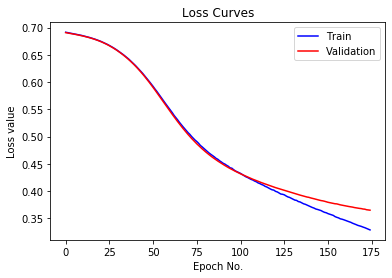

In [18]:
#filtering the data set to include only the two classes
classes = [b'airplane', b'ship']
class0 = labelNames.index(classes[0])
class1 = labelNames.index(classes[1])

trainX = trainImages[(trainLabels == class0) | (trainLabels == class1)]
trainY = trainLabels[(trainLabels == class0) | (trainLabels == class1)]
trainY[trainY == class0] = 0
trainY[trainY == class1] = 1

testX = testImages[(testLabels == class0) | (testLabels == class1)]
testY = testLabels[(testLabels == class0) | (testLabels == class1)]
testY[testY == class0] = 0
testY[testY == class1] = 1


#extracting the HOG features
trainX = np.array([hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                       transform_sqrt=True, block_norm="L1") for image in trainX])
testX = np.array([hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                       transform_sqrt=True, block_norm="L1") for image in testX])


#normalizing the data
mean = np.mean(trainX, axis=0, keepdims=True)
std = np.std(trainX, axis=0, keepdims=True)
trainX = (trainX - mean)/std
testX = (testX - mean)/std


#values of hyperparameters
SEED = 100
VAL_SPLIT = 0.2
BATCH_SIZE = 1024
NUM_EPOCHS = 175
LEARNING_RATE = 0.01


#splitting the training set into training and validation sets
np.random.seed(SEED)
indices = np.arange(len(trainX))
np.random.shuffle(indices)
valX = trainX[indices[:int(VAL_SPLIT*len(indices))]]
valY = trainY[indices[:int(VAL_SPLIT*len(indices))]]
trainX = trainX[indices[int(VAL_SPLIT*len(indices)):]]
trainY = trainY[indices[int(VAL_SPLIT*len(indices)):]]


#Model architecture
class Net(Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = Linear(288,512,LEARNING_RATE)
        self.afunc1 = ReLU()
        self.fc2 = Linear(512,128,LEARNING_RATE)
        self.afunc2 = ReLU()
        self.fc3 = Linear(128,32,LEARNING_RATE)
        self.afunc3 = ReLU()
        self.fc4 = Linear(32,2,LEARNING_RATE)
        self.afunc4 = Softmax()
        return
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.afunc1.forward(x)
        x = self.fc2.forward(x)
        x = self.afunc2.forward(x)
        x = self.fc3.forward(x)
        x = self.afunc3.forward(x)
        x = self.fc4.forward(x)
        x = self.afunc4.forward(x)
        return x
    
    def backward(self, gradients):
        gradients = self.afunc4.backward(gradients)
        gradients = self.fc4.backward(gradients)
        gradients = self.afunc3.backward(gradients)
        gradients = self.fc3.backward(gradients)
        gradients = self.afunc2.backward(gradients)
        gradients = self.fc2.backward(gradients)
        gradients = self.afunc1.backward(gradients)
        gradients = self.fc1.backward(gradients)
        return
    
    def step(self):
        self.fc1.step()
        self.fc2.step()
        self.fc3.step()
        self.fc4.step()
        return
    
    def num_params(self):
        numParams = 0
        numParams = numParams + self.fc1.num_params()
        numParams = numParams + self.fc2.num_params()
        numParams = numParams + self.fc3.num_params()
        numParams = numParams + self.fc4.num_params()
        return numParams
    
    
#loss function and model initialization
loss_function = CrossEntropyLoss()
model = Net()
print("\nNumber of Parameters in Model = " + str(model.num_params()))


print('\nTraining the model .... \n')
trainingLossCurve = []
validationLossCurve = []
for epoch in range(1, NUM_EPOCHS+1):
    
    #shuffle the dataset so the composition of batches differs every epoch
    indices = np.arange(len(trainX))
    np.random.shuffle(indices)
    trainX = trainX[indices]
    trainY = trainY[indices]
    
    #train for one epoch and obtain the training set loss and accuracy
    trainingLoss, trainingAccuracy = train(model, trainX, trainY, loss_function)
    trainingLossCurve.append(trainingLoss)
    
    #obtain the validation set loss and accuracy
    validationLoss, validationAccuracy = validate(model, valX, valY, loss_function)
    validationLossCurve.append(validationLoss)
    print('Epoch: %d, Tr.Loss: %.6f, Val.Loss: %.6f, Tr.Acc: %.3f, Val.Acc: %.3f' 
          %(epoch, trainingLoss, validationLoss, trainingAccuracy, validationAccuracy))


    
print('\nTesting the model .... \n')
#obtain the test set loss and accuracy
testLoss, testAccuracy = test(model, testX, testY, loss_function)
print('Test Loss: %.6f, Test Accuracy: %.3f' %(testLoss, testAccuracy))


#plot the training loss and validation loss curves
plt.figure()
plt.title('Loss Curves')
plt.xlabel('Epoch No.')
plt.ylabel('Loss value')
plt.plot(trainingLossCurve, 'b', label='Train')
plt.plot(validationLossCurve, 'r', label='Validation')
plt.legend()
plt.show()

### Five classes

We filter the data set to include the `Cat`, `Deer`, `Dog`, `Frog` and `Horse` classes. We assign labels from $0$ to $4$ in the given order to the classes. We use the Histogram of Oriented Gradients (HOG) Descriptors as feature vectors. We extract $288$ HOG features for each image. We normalize the data using `mean` and `std` and split the training set into training ($80\%$) and validation ($20\%$) sets. 


The Neural Network architecture used consists of $1$ input layer, $4$ hidden layers each with `ReLU` activation and $1$ output layer with `Softmax` activation so that the model output is a probability distribution. We use the `Cross Entropy` Loss function to train the network.

The hyperparameter values used are:
- Batch Size = $512$
- Epochs = $250$
- Learning Rate = $0.005$


Number of Parameters in Model = 296869

Training the model .... 

Epoch: 1, Tr.Loss: 1.610659, Val.Loss: 1.611731, Tr.Acc: 0.200, Val.Acc: 0.191
Epoch: 2, Tr.Loss: 1.610388, Val.Loss: 1.611154, Tr.Acc: 0.199, Val.Acc: 0.191
Epoch: 3, Tr.Loss: 1.609369, Val.Loss: 1.610614, Tr.Acc: 0.201, Val.Acc: 0.191
Epoch: 4, Tr.Loss: 1.609076, Val.Loss: 1.610086, Tr.Acc: 0.200, Val.Acc: 0.191
Epoch: 5, Tr.Loss: 1.608740, Val.Loss: 1.609565, Tr.Acc: 0.199, Val.Acc: 0.191
Epoch: 6, Tr.Loss: 1.607420, Val.Loss: 1.609146, Tr.Acc: 0.206, Val.Acc: 0.191
Epoch: 7, Tr.Loss: 1.607279, Val.Loss: 1.608735, Tr.Acc: 0.204, Val.Acc: 0.191
Epoch: 8, Tr.Loss: 1.607429, Val.Loss: 1.608278, Tr.Acc: 0.201, Val.Acc: 0.191
Epoch: 9, Tr.Loss: 1.607052, Val.Loss: 1.607827, Tr.Acc: 0.200, Val.Acc: 0.192
Epoch: 10, Tr.Loss: 1.606455, Val.Loss: 1.607358, Tr.Acc: 0.201, Val.Acc: 0.193
Epoch: 11, Tr.Loss: 1.606151, Val.Loss: 1.606965, Tr.Acc: 0.204, Val.Acc: 0.195
Epoch: 12, Tr.Loss: 1.605361, Val.Loss: 1.606582, Tr.Acc: 0.21

Epoch: 103, Tr.Loss: 1.270496, Val.Loss: 1.295080, Tr.Acc: 0.481, Val.Acc: 0.464
Epoch: 104, Tr.Loss: 1.265754, Val.Loss: 1.291312, Tr.Acc: 0.486, Val.Acc: 0.466
Epoch: 105, Tr.Loss: 1.258462, Val.Loss: 1.287357, Tr.Acc: 0.486, Val.Acc: 0.467
Epoch: 106, Tr.Loss: 1.252165, Val.Loss: 1.283303, Tr.Acc: 0.490, Val.Acc: 0.469
Epoch: 107, Tr.Loss: 1.255240, Val.Loss: 1.279760, Tr.Acc: 0.487, Val.Acc: 0.471
Epoch: 108, Tr.Loss: 1.247500, Val.Loss: 1.276314, Tr.Acc: 0.490, Val.Acc: 0.472
Epoch: 109, Tr.Loss: 1.241020, Val.Loss: 1.273659, Tr.Acc: 0.495, Val.Acc: 0.472
Epoch: 110, Tr.Loss: 1.236813, Val.Loss: 1.269201, Tr.Acc: 0.497, Val.Acc: 0.478
Epoch: 111, Tr.Loss: 1.233340, Val.Loss: 1.266140, Tr.Acc: 0.497, Val.Acc: 0.477
Epoch: 112, Tr.Loss: 1.228906, Val.Loss: 1.262939, Tr.Acc: 0.499, Val.Acc: 0.481
Epoch: 113, Tr.Loss: 1.229660, Val.Loss: 1.260437, Tr.Acc: 0.501, Val.Acc: 0.480
Epoch: 114, Tr.Loss: 1.225504, Val.Loss: 1.256882, Tr.Acc: 0.504, Val.Acc: 0.482
Epoch: 115, Tr.Loss: 1.22069

Epoch: 205, Tr.Loss: 0.926874, Val.Loss: 1.068303, Tr.Acc: 0.640, Val.Acc: 0.573
Epoch: 206, Tr.Loss: 0.925136, Val.Loss: 1.067546, Tr.Acc: 0.639, Val.Acc: 0.575
Epoch: 207, Tr.Loss: 0.922460, Val.Loss: 1.066656, Tr.Acc: 0.642, Val.Acc: 0.569
Epoch: 208, Tr.Loss: 0.926678, Val.Loss: 1.066184, Tr.Acc: 0.637, Val.Acc: 0.571
Epoch: 209, Tr.Loss: 0.919291, Val.Loss: 1.066357, Tr.Acc: 0.644, Val.Acc: 0.573
Epoch: 210, Tr.Loss: 0.914038, Val.Loss: 1.064437, Tr.Acc: 0.646, Val.Acc: 0.574
Epoch: 211, Tr.Loss: 0.913319, Val.Loss: 1.064668, Tr.Acc: 0.643, Val.Acc: 0.574
Epoch: 212, Tr.Loss: 0.908167, Val.Loss: 1.064020, Tr.Acc: 0.648, Val.Acc: 0.572
Epoch: 213, Tr.Loss: 0.907983, Val.Loss: 1.060771, Tr.Acc: 0.646, Val.Acc: 0.578
Epoch: 214, Tr.Loss: 0.908761, Val.Loss: 1.062699, Tr.Acc: 0.648, Val.Acc: 0.573
Epoch: 215, Tr.Loss: 0.907842, Val.Loss: 1.063675, Tr.Acc: 0.648, Val.Acc: 0.574
Epoch: 216, Tr.Loss: 0.898042, Val.Loss: 1.059246, Tr.Acc: 0.651, Val.Acc: 0.576
Epoch: 217, Tr.Loss: 0.90560

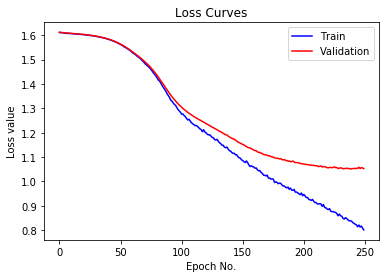

In [11]:
#filtering the data to include only the five classes
classes = [b'cat', b'deer', b'dog', b'frog', b'horse']
class0 = labelNames.index(classes[0])
class1 = labelNames.index(classes[1])
class2 = labelNames.index(classes[2])
class3 = labelNames.index(classes[3])
class4 = labelNames.index(classes[4])

trainX = trainImages[(trainLabels == class0) | (trainLabels == class1) | (trainLabels == class2) | 
                     (trainLabels == class3) | (trainLabels == class4)]
trainY = trainLabels[(trainLabels == class0) | (trainLabels == class1) | (trainLabels == class2) | 
                     (trainLabels == class3) | (trainLabels == class4)]
trainY[trainY == class0] = 0
trainY[trainY == class1] = 1
trainY[trainY == class2] = 2
trainY[trainY == class3] = 3
trainY[trainY == class4] = 4

testX = testImages[(testLabels == class0) | (testLabels == class1) | (testLabels == class2) | 
                   (testLabels == class3) | (testLabels == class4)]
testY = testLabels[(testLabels == class0) | (testLabels == class1) | (testLabels == class2) | 
                   (testLabels == class3) | (testLabels == class4)]
testY[testY == class0] = 0
testY[testY == class1] = 1
testY[testY == class2] = 2
testY[testY == class3] = 3
testY[testY == class4] = 4


#extracting the HOG features
trainX = np.array([hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                       transform_sqrt=True, block_norm="L1") for image in trainX])
testX = np.array([hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                       transform_sqrt=True, block_norm="L1") for image in testX])


#normalizing the data set
mean = np.mean(trainX, axis=0, keepdims=True)
std = np.std(trainX, axis=0, keepdims=True)
trainX = (trainX - mean)/std
testX = (testX - mean)/std


#values of the hyperparameters
SEED = 100
VAL_SPLIT = 0.2
BATCH_SIZE = 512
NUM_EPOCHS = 250
LEARNING_RATE = 0.005


#splitting the training set into training and validation set
np.random.seed(SEED)
indices = np.arange(len(trainX))
np.random.shuffle(indices)
valX = trainX[indices[:int(VAL_SPLIT*len(indices))]]
valY = trainY[indices[:int(VAL_SPLIT*len(indices))]]
trainX = trainX[indices[int(VAL_SPLIT*len(indices)):]]
trainY = trainY[indices[int(VAL_SPLIT*len(indices)):]]


#Model architecture
class Net(Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = Linear(288,512,LEARNING_RATE)
        self.afunc1 = ReLU()
        self.fc2 = Linear(512,256,LEARNING_RATE)
        self.afunc2 = ReLU()
        self.fc3 = Linear(256,64,LEARNING_RATE)
        self.afunc3 = ReLU()
        self.fc4 = Linear(64,16,LEARNING_RATE)
        self.afunc4 = ReLU()
        self.fc5 = Linear(16,5,LEARNING_RATE)
        self.afunc5 = Softmax()
        return
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.afunc1.forward(x)
        x = self.fc2.forward(x)
        x = self.afunc2.forward(x)
        x = self.fc3.forward(x)
        x = self.afunc3.forward(x)
        x = self.fc4.forward(x)
        x = self.afunc4.forward(x)
        x = self.fc5.forward(x)
        x = self.afunc5.forward(x)
        return x
    
    def backward(self, gradients):
        gradients = self.afunc5.backward(gradients)
        gradients = self.fc5.backward(gradients)
        gradients = self.afunc4.backward(gradients)
        gradients = self.fc4.backward(gradients)
        gradients = self.afunc3.backward(gradients)
        gradients = self.fc3.backward(gradients)
        gradients = self.afunc2.backward(gradients)
        gradients = self.fc2.backward(gradients)
        gradients = self.afunc1.backward(gradients)
        gradients = self.fc1.backward(gradients)
        return
    
    def step(self):
        self.fc1.step()
        self.fc2.step()
        self.fc3.step()
        self.fc4.step()
        self.fc5.step()
        return
    
    def num_params(self):
        numParams = 0
        numParams = numParams + self.fc1.num_params()
        numParams = numParams + self.fc2.num_params()
        numParams = numParams + self.fc3.num_params()
        numParams = numParams + self.fc4.num_params()
        numParams = numParams + self.fc5.num_params()
        return numParams
    
    
#loss function and model initialization
loss_function = CrossEntropyLoss()
model = Net()
print("\nNumber of Parameters in Model = " + str(model.num_params()))


print('\nTraining the model .... \n')
trainingLossCurve = []
validationLossCurve = []
for epoch in range(1, NUM_EPOCHS+1):
    
    #shuffle the dataset so that the composition of batches differs every epoch
    indices = np.arange(len(trainX))
    np.random.shuffle(indices)
    trainX = trainX[indices]
    trainY = trainY[indices]
    
    #train the model for one epoch and obtain the training set loss and accuracy
    trainingLoss, trainingAccuracy = train(model, trainX, trainY, loss_function)
    trainingLossCurve.append(trainingLoss)
    
    #obtain the validation set loss and accuracy
    validationLoss, validationAccuracy = validate(model, valX, valY, loss_function)
    validationLossCurve.append(validationLoss)
    print('Epoch: %d, Tr.Loss: %.6f, Val.Loss: %.6f, Tr.Acc: %.3f, Val.Acc: %.3f' 
          %(epoch, trainingLoss, validationLoss, trainingAccuracy, validationAccuracy))


#obtain the test set loss and accuracy    
print('\nTesting the model .... \n')
testLoss, testAccuracy = test(model, testX, testY, loss_function)
print('Test Loss: %.6f, Test Accuracy: %.3f' %(testLoss, testAccuracy))


#plotting the training and validation loss curves
plt.figure()
plt.title('Loss Curves')
plt.xlabel('Epoch No.')
plt.ylabel('Loss value')
plt.plot(trainingLossCurve, 'b', label='Train')
plt.plot(validationLossCurve, 'r', label='Validation')
plt.legend()
plt.show()